# Predicting successfull startups


###**Import of data and relevant libaries**

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import graphviz
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold,RFECV
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,RepeatedStratifiedKFold,StratifiedKFold
from imblearn.over_sampling import SMOTE

startup_df = pd.read_csv("investments_VC.csv", delimiter=',', header = 0, encoding = "ISO-8859-1",skipinitialspace=True)
startup_df = startup_df.rename(columns={'market ': 'market', 'funding_total_usd ': 'funding_total_usd'})


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


FileNotFoundError: ignored

###**1.General overview**

In [ ]:
startup_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54294 entries, 0 to 54293
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   permalink             49438 non-null  object 
 1   name                  49437 non-null  object 
 2   homepage_url          45989 non-null  object 
 3   category_list         45477 non-null  object 
 4   market                45470 non-null  object 
 5   funding_total_usd     49438 non-null  object 
 6   status                48124 non-null  object 
 7   country_code          44165 non-null  object 
 8   state_code            30161 non-null  object 
 9   region                44165 non-null  object 
 10  city                  43322 non-null  object 
 11  funding_rounds        49438 non-null  float64
 12  founded_at            38554 non-null  object 
 13  founded_month         38482 non-null  object 
 14  founded_quarter       38482 non-null  object 
 15  founded_year       

In [ ]:
#Based on the .info() function, we can identify that some data variables need to be converted into a date type.
format_date = ('founded_at','first_funding_at','last_funding_at')
for i in format_date:
  startup_df[i] = pd.to_datetime(startup_df[i], format = '%Y-%m-%d', errors = 'coerce')

In [ ]:
startup_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4480 entries, 0 to 49430
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  4480 non-null   object 
 1   market                4480 non-null   object 
 2   country_code          4480 non-null   object 
 3   funding_rounds        4480 non-null   float64
 4   founded_month         4480 non-null   float64
 5   founded_quarter       4480 non-null   float64
 6   founded_year          4480 non-null   float64
 7   seed                  4480 non-null   float64
 8   venture               4480 non-null   float64
 9   equity_crowdfunding   4480 non-null   float64
 10  undisclosed           4480 non-null   float64
 11  convertible_note      4480 non-null   float64
 12  debt_financing        4480 non-null   float64
 13  angel                 4480 non-null   float64
 14  grant                 4480 non-null   float64
 15  private_equity      

In [ ]:
startup_df.country_code.value_counts()

USA    3372
GBR     226
CAN     140
DEU      92
ISR      89
       ... 
NGA       1
VNM       1
COL       1
BHR       1
MAF       1
Name: country_code, Length: 65, dtype: int64

In [ ]:
startup_df.market.value_counts()

Software                 546
Curated Web              298
Mobile                   265
Enterprise Software      192
Biotechnology            187
                        ... 
Semantic Search            1
IT and Cybersecurity       1
FreetoPlay Gaming          1
Women                      1
Cooking                    1
Name: market, Length: 380, dtype: int64

In [ ]:
startup_df.describe()

,funding_rounds,founded_year,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
count,49438.000000,38482.000000,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,...,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04
mean,1.696205,2007.359129,2.173215e+05,7.501051e+06,6.163322e+03,1.302213e+05,2.336410e+04,1.888157e+06,6.541898e+04,1.628453e+05,...,3.845592e+04,7.074227e+03,1.243955e+06,1.492891e+06,1.205356e+06,7.375261e+05,3.424682e+05,1.697692e+05,5.767067e+04,1.423197e+04
std,1.294213,7.579203,1.056985e+06,2.847112e+07,1.999048e+05,2.981404e+06,1.432046e+06,1.382046e+08,6.582908e+05,5.612088e+06,...,3.864461e+06,4.282166e+05,5.531974e+06,7.472704e+06,7.993592e+06,9.815218e+06,5.406915e+06,6.277905e+06,5.252312e+06,2.716865e+06
min,1.000000,1902.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000,2006.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000,2010.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.000000,2012.000000,2.500000e+04,5.000000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,18.000000,2014.000000,1.300000e+08,2.351000e+09,2.500000e+07,2.924328e+08,3.000000e+08,3.007950e+10,6.359026e+07,7.505000e+08,...,6.806116e+08,7.200000e+07,3.190000e+08,5.420000e+08,4.900000e+08,1.200000e+09,4.000000e+08,1.060000e+09,1.000000e+09,6.000000e+08


###**2.Initial Data Preparation**
Preparing for exploration

In [ ]:
startup_df.head(1)

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,"17,50,000",acquired,USA,NY,New York City,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#To reduce the complexity, while processing the date variable fields, we convert the actual dates to 
#relative dates, describing the distance from founded to first and last funding and then drop the founded date.

startup_df['age_first_funding'] = (startup_df['first_funding_at']-startup_df['founded_at'])/pd.Timedelta(days=365)
startup_df['age_last_funding'] = (startup_df['last_funding_at']-startup_df['founded_at'])/pd.Timedelta(days=365)
startup_df['founded_month'] = pd.DatetimeIndex(startup_df['founded_at']).month
startup_df['founded_quarter'] = pd.DatetimeIndex(startup_df['founded_at']).quarter


In [ ]:
startup_df.isnull().sum()

permalink                4856
name                     4857
homepage_url             8305
category_list            8817
market                   8824
funding_total_usd        4856
status                   6170
country_code            10129
state_code              24133
region                  10129
city                    10972
funding_rounds           4856
founded_at              15741
founded_month           15741
founded_quarter         15741
founded_year            15812
first_funding_at         4866
last_funding_at          4862
seed                     4856
venture                  4856
equity_crowdfunding      4856
undisclosed              4856
convertible_note         4856
debt_financing           4856
angel                    4856
grant                    4856
private_equity           4856
post_ipo_equity          4856
post_ipo_debt            4856
secondary_market         4856
product_crowdfunding     4856
round_A                  4856
round_B                  4856
round_C   

In [ ]:
#As the dataset contains quite many null-values, we try to reduce the amount null-values by
#deleting the rows with a few central variables containing null
startup_df = startup_df.drop(startup_df[
                                        (
                                        (startup_df['status'].isna())|
                                        (startup_df['founded_month'].isna())|
                                        (startup_df['founded_year'].isna())|
                                        (startup_df['market'].isna())|
                                        (startup_df['country_code'].isna())|
                                        (startup_df['funding_total_usd'].isna())|
                                        (startup_df['age_first_funding'].isna())
                                        )
                                        ].index)
#With a general removal of all observations containing null-values, we have 28290 observations remaining
startup_df.shape

(33147, 41)

In [ ]:
#Based on the cleaning above, we would now like to see, 
#how many observations for each column that contains null-values.

startup_df.isnull().sum()

permalink                  0
name                       0
homepage_url            1621
category_list              0
market                     0
funding_total_usd          0
status                     0
country_code               0
state_code              9909
region                     0
city                     387
funding_rounds             0
founded_at                 0
founded_month              0
founded_quarter            0
founded_year               0
first_funding_at           0
last_funding_at            0
seed                       0
venture                    0
equity_crowdfunding        0
undisclosed                0
convertible_note           0
debt_financing             0
angel                      0
grant                      0
private_equity             0
post_ipo_equity            0
post_ipo_debt              0
secondary_market           0
product_crowdfunding       0
round_A                    0
round_B                    0
round_C                    0
round_D       

In [ ]:
#Excluding irrelevant variables, assumed cannot be used to predict the success of a start-up
#Funding_total_USD is excluded, as this is an aggregation of angel and seed

#We, however keep the name of the startup to correctly distinct between them the futher analysis
startup_df = startup_df.drop(
    [
     'permalink'
#     ,'name'
     ,'homepage_url'
     ,'state_code'
     ,'region'
     ,'city'
     ,'founded_at'
     ,'first_funding_at'
     ,'funding_total_usd'
     ,'last_funding_at'
     ,'category_list'
     ], axis = 1)

In [ ]:
#Further, we can check that we do not have any duplicates in our dataset
startup_df = startup_df.drop_duplicates()
startup_df.shape

(33147, 31)

In [ ]:
startup_df.to_csv('cleaned_dataset.csv', index =False)


In [ ]:
# Get training and test sets
from sklearn.model_selection import train_test_split

X = startup_df[startup_df.loc[:, startup_df.columns != 'status'].columns]
y = startup_df['status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

NameError: ignored

In [ ]:
print('Before')
display(startup_df.groupby('status').agg({'country_code':'count'}).sort_values(by=['status'], ascending = False))
StatusDict = {"closed":0,"acquired":1}

startup_df = startup_df[(startup_df['status'] == 'acquired') | (startup_df['status'] == 'closed')]
startup_df["status_binary"] = startup_df["status"].map(StatusDict)
startup_df = startup_df.drop(['status'], axis = 1)

print('After')
display(startup_df.groupby('status_binary').agg({'country_code':'count'}).sort_values(by=['status_binary'], ascending = True))


Before


,country_code
status,
operating,28667
closed,1717
acquired,2763


After


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,country_code
status_binary,
0,1717
1,2763


In [ ]:
corr = startup_df.corr()

corr.style.background_gradient(cmap='coolwarm')

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,funding_rounds,founded_month,founded_quarter,founded_year,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H,age_first_funding,age_last_funding,status_binary
funding_rounds,1.000000,-0.028781,-0.025448,-0.069000,0.042533,0.492729,-0.002718,0.054336,0.067992,0.138597,0.025355,0.068839,0.089577,0.021611,0.030327,0.023314,0.010612,0.174099,0.327010,0.358117,0.258699,0.206549,0.116455,0.057881,nan,-0.071892,0.197990,0.239897
founded_month,-0.028781,1.000000,0.980774,0.258619,0.053880,-0.084995,-0.013613,-0.032692,-0.014376,-0.019583,0.047568,-0.018758,-0.039267,0.025774,0.029829,-0.010564,0.018267,-0.012355,-0.042187,-0.027554,-0.039353,-0.037781,-0.020741,0.019862,nan,-0.270933,-0.287476,-0.131630
founded_quarter,-0.025448,0.980774,1.000000,0.231727,0.048118,-0.072130,-0.012420,-0.030952,-0.012863,-0.016292,0.041486,-0.017199,-0.036677,0.031822,0.035135,-0.009638,0.022447,-0.004394,-0.033966,-0.021748,-0.034454,-0.036519,-0.018965,0.018487,nan,-0.247083,-0.262356,-0.118258
founded_year,-0.069000,0.258619,0.231727,1.000000,0.127394,-0.161967,0.008688,-0.073875,0.003100,-0.064446,0.036628,-0.040118,-0.061871,-0.032454,-0.006220,-0.065296,0.018714,-0.014905,-0.064071,-0.087615,-0.075602,-0.048954,-0.019725,-0.023554,nan,-0.868741,-0.883474,-0.240000
seed,0.042533,0.053880,0.048118,0.127394,1.000000,-0.022519,-0.004741,-0.015967,-0.007452,-0.015728,-0.006508,-0.006678,0.023600,-0.004526,-0.004356,-0.003711,-0.004029,0.014760,0.025331,-0.020327,-0.023411,-0.021794,-0.009480,-0.005964,nan,-0.091392,-0.087742,0.017859
venture,0.492729,-0.084995,-0.072130,-0.161967,-0.022519,1.000000,-0.008339,-0.024309,0.013162,0.370390,-0.031763,0.026347,0.151851,-0.007754,-0.003332,0.004842,0.042956,0.470009,0.661565,0.639217,0.532401,0.437324,0.451712,0.111308,nan,0.050396,0.201612,0.180415
equity_crowdfunding,-0.002718,-0.013613,-0.012420,0.008688,-0.004741,-0.008339,1.000000,-0.001314,-0.000480,-0.001355,0.014394,-0.000570,-0.001693,-0.000371,-0.000357,-0.000304,-0.000330,-0.005363,-0.005868,-0.005157,-0.002865,-0.001813,-0.000815,-0.000489,nan,0.007114,0.006753,0.015606
undisclosed,0.054336,-0.032692,-0.030952,-0.073875,-0.015967,-0.024309,-0.001314,1.000000,-0.002687,-0.003031,-0.008763,-0.001912,-0.005178,-0.001244,-0.001197,-0.001020,-0.001107,-0.013836,-0.013431,-0.017291,-0.009600,-0.006074,-0.002732,-0.001639,nan,0.000819,0.008440,0.047615
convertible_note,0.067992,-0.014376,-0.012863,0.003100,-0.007452,0.013162,-0.000480,-0.002687,1.000000,-0.000400,-0.002870,-0.001170,-0.003475,-0.000761,-0.000733,-0.000624,-0.000678,0.002255,0.038134,0.003510,0.002673,-0.001412,-0.001672,-0.001003,nan,-0.006206,0.012053,-0.013741
debt_financing,0.138597,-0.019583,-0.016292,-0.064446,-0.015728,0.370390,-0.001355,-0.003031,-0.000400,1.000000,-0.003603,0.003530,0.312724,-0.001284,-0.001236,-0.000425,-0.001143,0.052005,0.233316,0.131484,0.183142,0.400903,0.521409,-0.000019,nan,0.070608,0.093510,0.023802


In [ ]:
#Hence, the format of funding_total_USD is distorted, we are aggregating a new attribute 

startup_df['total_investment'] = startup_df['seed'] + startup_df['venture'] +startup_df['equity_crowdfunding'] + startup_df['undisclosed'] + startup_df['convertible_note'] + startup_df['debt_financing'] + startup_df['angel'] + startup_df['grant'] + startup_df['private_equity'] + startup_df['post_ipo_equity'] + startup_df['post_ipo_debt'] + startup_df['secondary_market'] + startup_df['product_crowdfunding']

startup_df['total_investment'].describe()


count    4.480000e+03
mean     1.654188e+07
std      9.863946e+07
min      0.000000e+00
25%      3.000000e+05
50%      3.366250e+06
75%      1.440000e+07
max      5.700000e+09
Name: total_investment, dtype: float64

In [ ]:
max(startup_df['total_investment'])

5700000000.0

### Visualisation

In [ ]:
df = pd.read_csv('cleaned_dataset.csv')

In [ ]:
df.reset_index(inplace= True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33147 entries, 0 to 33146
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 33147 non-null  int64  
 1   name                  33147 non-null  object 
 2   market                33147 non-null  object 
 3   status                33147 non-null  object 
 4   country_code          33147 non-null  object 
 5   funding_rounds        33147 non-null  float64
 6   founded_month         33147 non-null  float64
 7   founded_quarter       33147 non-null  float64
 8   founded_year          33147 non-null  float64
 9   seed                  33147 non-null  float64
 10  venture               33147 non-null  float64
 11  equity_crowdfunding   33147 non-null  float64
 12  undisclosed           33147 non-null  float64
 13  convertible_note      33147 non-null  float64
 14  debt_financing        33147 non-null  float64
 15  angel              

In [ ]:
print('Before')
display(df.groupby('status').agg({'country_code':'count'}).sort_values(by=['status'], ascending = False))
StatusDict = {"closed":0,"acquired":1}

df = df[(df['status'] == 'acquired') | (df['status'] == 'closed')]
df["status_binary"] = df["status"].map(StatusDict)
df = df.drop(['status'], axis = 1)

print('After')
display(df.groupby('status_binary').agg({'country_code':'count'}).sort_values(by=['status_binary'], ascending = True))


Before


,country_code
status,
operating,28667
closed,1717
acquired,2763


After


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,country_code
status_binary,
0,1717
1,2763


In [ ]:
len(numerical_cols)

28

Index(['index', 'funding_rounds', 'founded_month', 'founded_quarter',
       'founded_year', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed',
       'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'post_ipo_equity', 'post_ipo_debt',
       'secondary_market', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H',
       'age_first_funding', 'age_last_funding'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

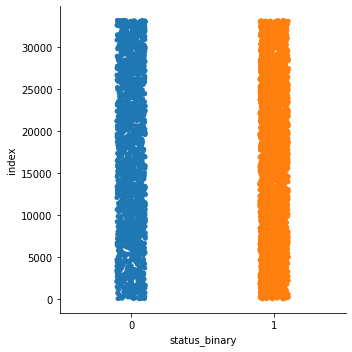

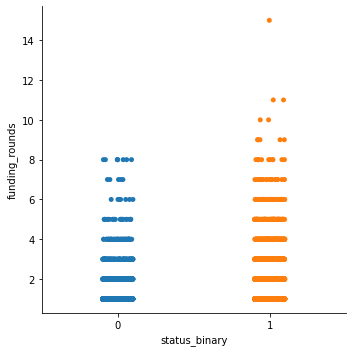

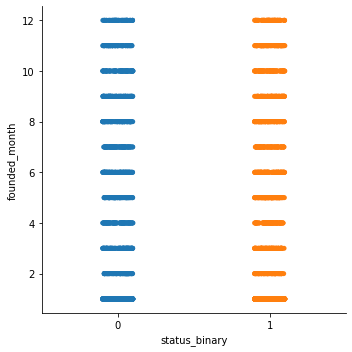

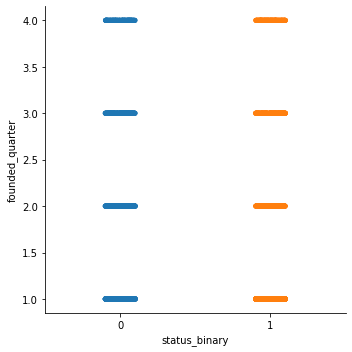

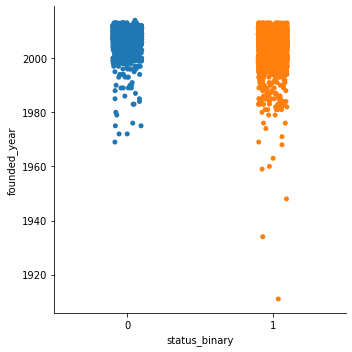

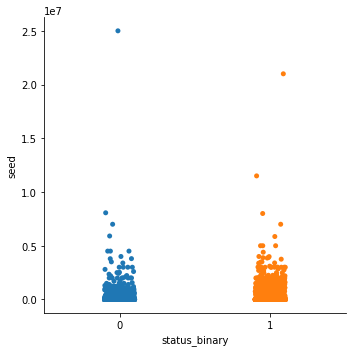

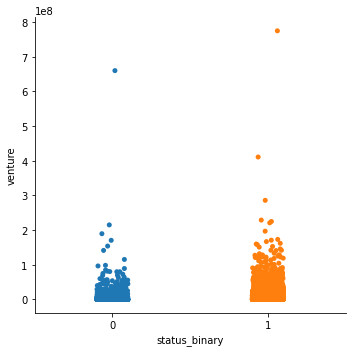

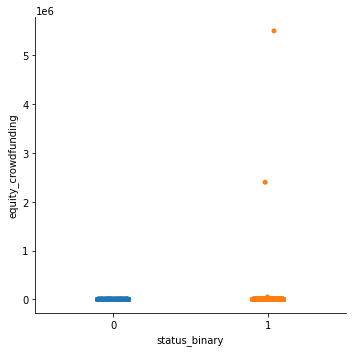

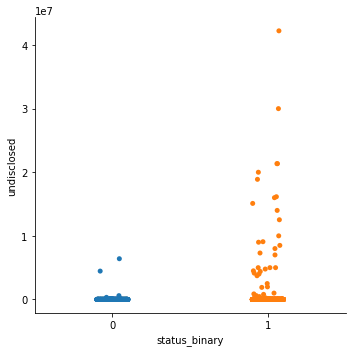

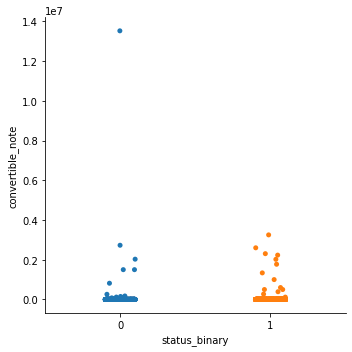

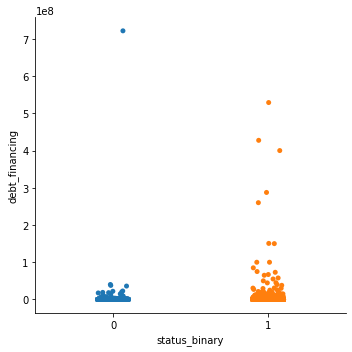

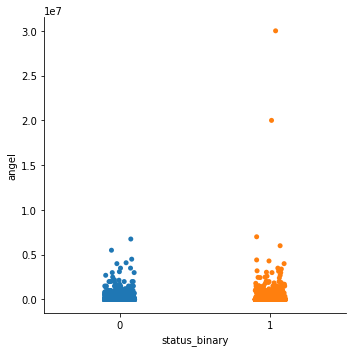

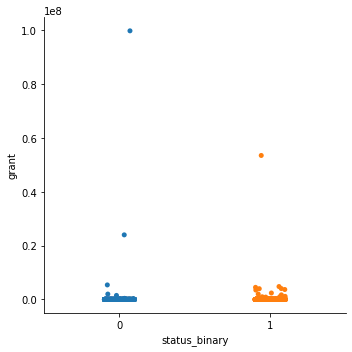

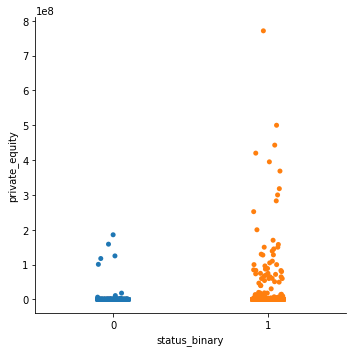

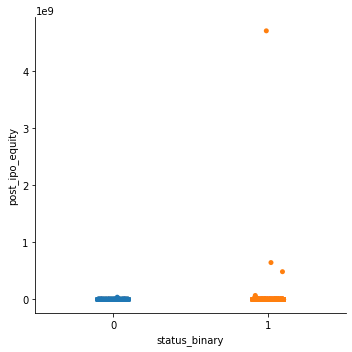

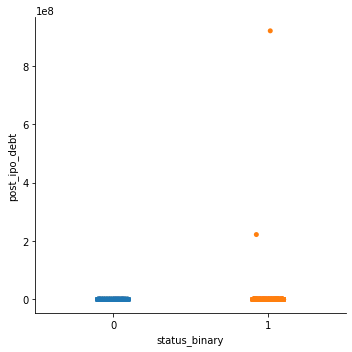

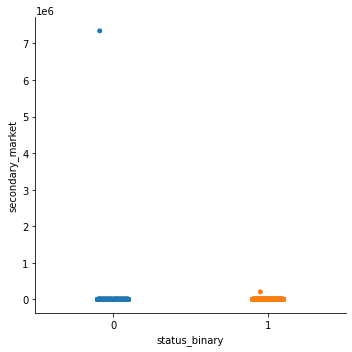

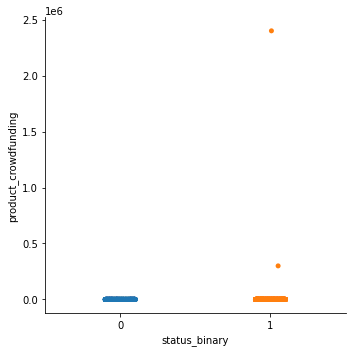

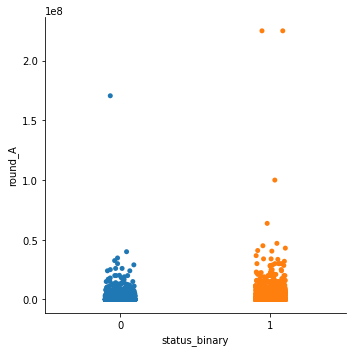

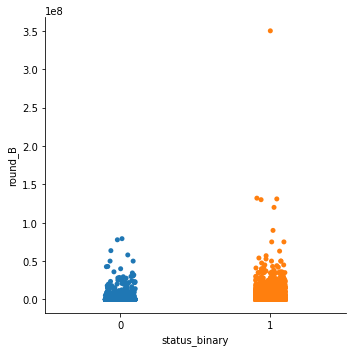

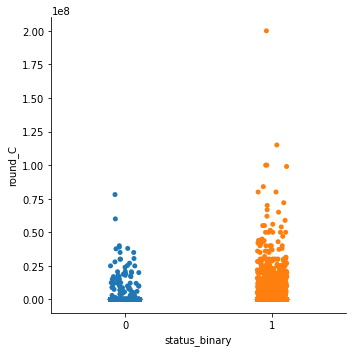

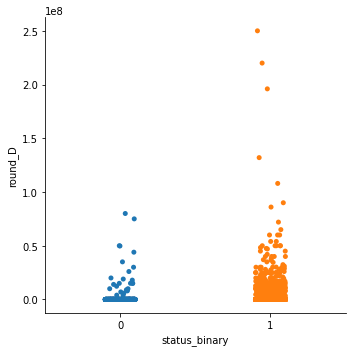

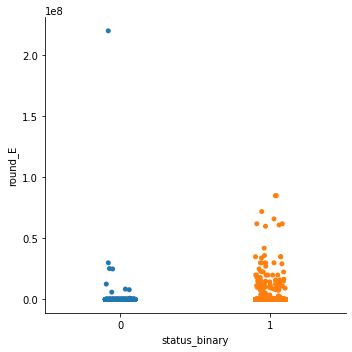

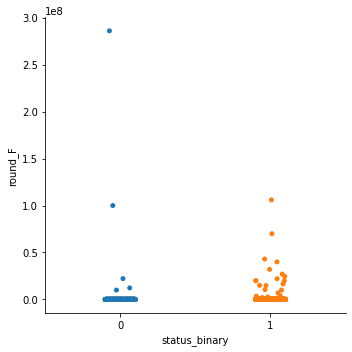

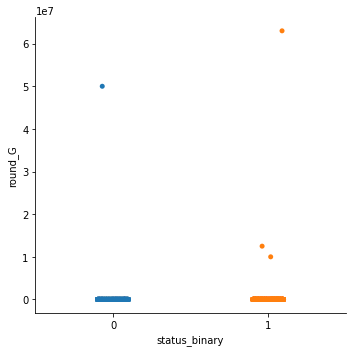

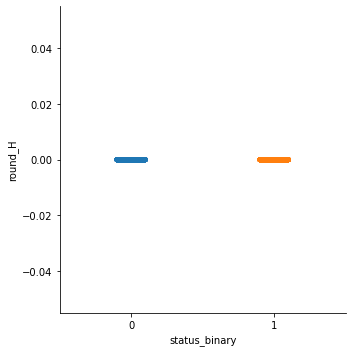

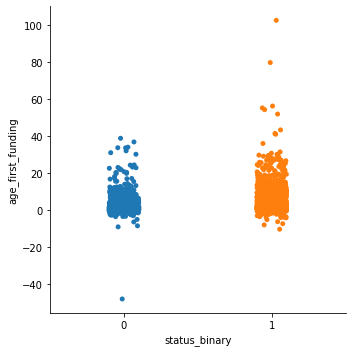

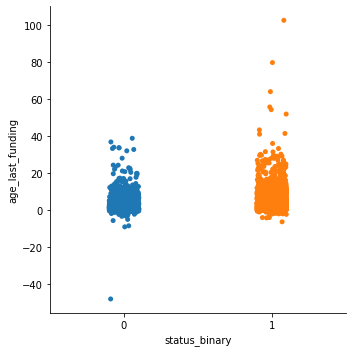

In [ ]:
all_cols = df.columns 
numerical_cols= all_cols.drop(['name', "market", "country_code", "status_binary"])
print(numerical_cols)


for col in numerical_cols:
  sns.catplot(x="status_binary", y=col, data=df)


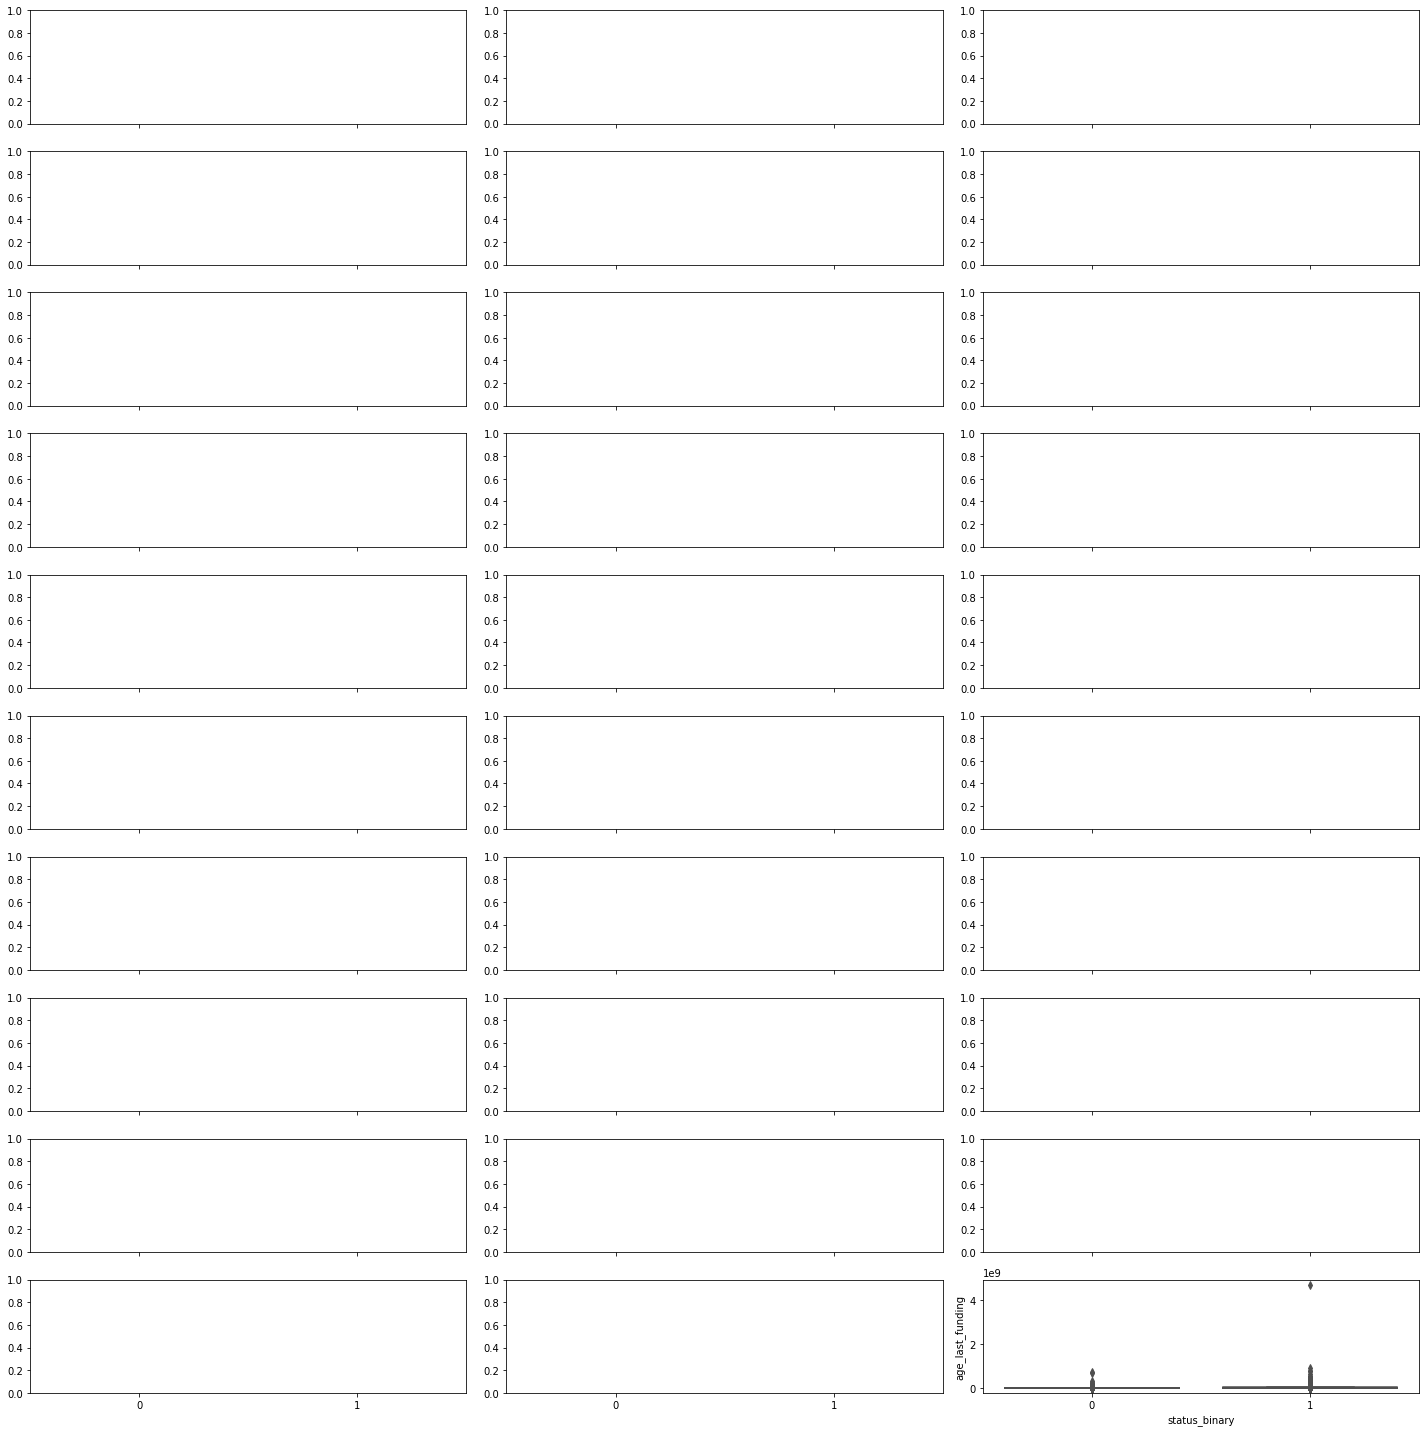

In [ ]:
# cat = ['sex', 'Aged', 'Married', 'TotalDependents', 'MobileService', '4GService', 'CyberProtection', 'HardwareSupport', 'TechnicalAssistance', 'FilmSubscription', 'SettlementProcess']
l = len(numerical_cols)

fig, axes =plt.subplots(10,3, figsize=(20,20), sharex=True)
axes = axes.flatten()
for i in range(l):
  sns.boxplot(x='status_binary',y=numerical_cols[i],data=df, palette='rainbow')
  # numerical_cols[i].plot(hue='status_binary',data = df, ax=axes[i])

plt.tight_layout()  
plt.show()

KeyError: ignored



###**3. Data Preparation**
Preparing for modelling


In [ ]:
#Exporting data to .CSV in order to explore data in Tableau
#startup_df.to_csv(r'startup_df_v1.csv', index = False, sep=';',mode='w')
#files.download('startup_df_v1.csv')

In [ ]:
startup_df.shape

(4480, 32)

#### 3.1 Funding sum and rounds

In [ ]:
#Removing outliers via IQR: Interquartile range, also called midspread.

Q1 = startup_df['total_investment'].quantile(0.25)
Q3 = startup_df['total_investment'].quantile(0.75)
IQR = Q3 - Q1

fund_lower = (Q1 - 1.5 * IQR)
fund_upper = (Q3 + 1.5 * IQR)

startup_df = startup_df[
                        (startup_df['total_investment'] >= fund_lower ) 
                        & (startup_df['total_investment'] <= fund_upper)
                        ]

print('The following code remove all datapoints below: {} and above {}'.format(fund_lower, fund_upper))
print('This results in the following data model: {}'.format(startup_df.shape))

The following code remove all datapoints below: -20850000.0 and above 35550000.0
This results in the following data model: (4011, 32)


#### 3.2 Markets


In [ ]:
top20_markets = startup_df['market'].value_counts()[:20].keys().tolist()
startup_df['market'] = startup_df['market'].apply(lambda i: i if i in top20_markets else 'Other')

#### 3.3 Age when funded

In [ ]:
#It looks like, some startups have recived funding prior to the date of establishment.

#startup_df['age_first_funding'] = startup_df['age_first_funding'].clip(lower=0, upper=None)
#startup_df['age_last_funding'] = startup_df['age_last_funding'].clip(lower=0, upper=None)


startup_df.loc[startup_df['age_first_funding'] < 0, 'age_first_funding'] = 0
startup_df.loc[startup_df['age_last_funding'] < 0, 'age_first_funding'] = 0

#### 3.4 Age when founded


In [ ]:
#The majority of the startups are located after 1994
#To further reduce the amount of outliers, we are excluding all startups before 1995.

startup_df = startup_df[(startup_df['founded_year'] >= 1995.0 )]

#### 3.5 Geographical data

In [ ]:
startup_df = startup_df.drop(
    [
     'country_code'
     ,'name'
     ], axis = 1)

#### 3.6 Correlation matrix


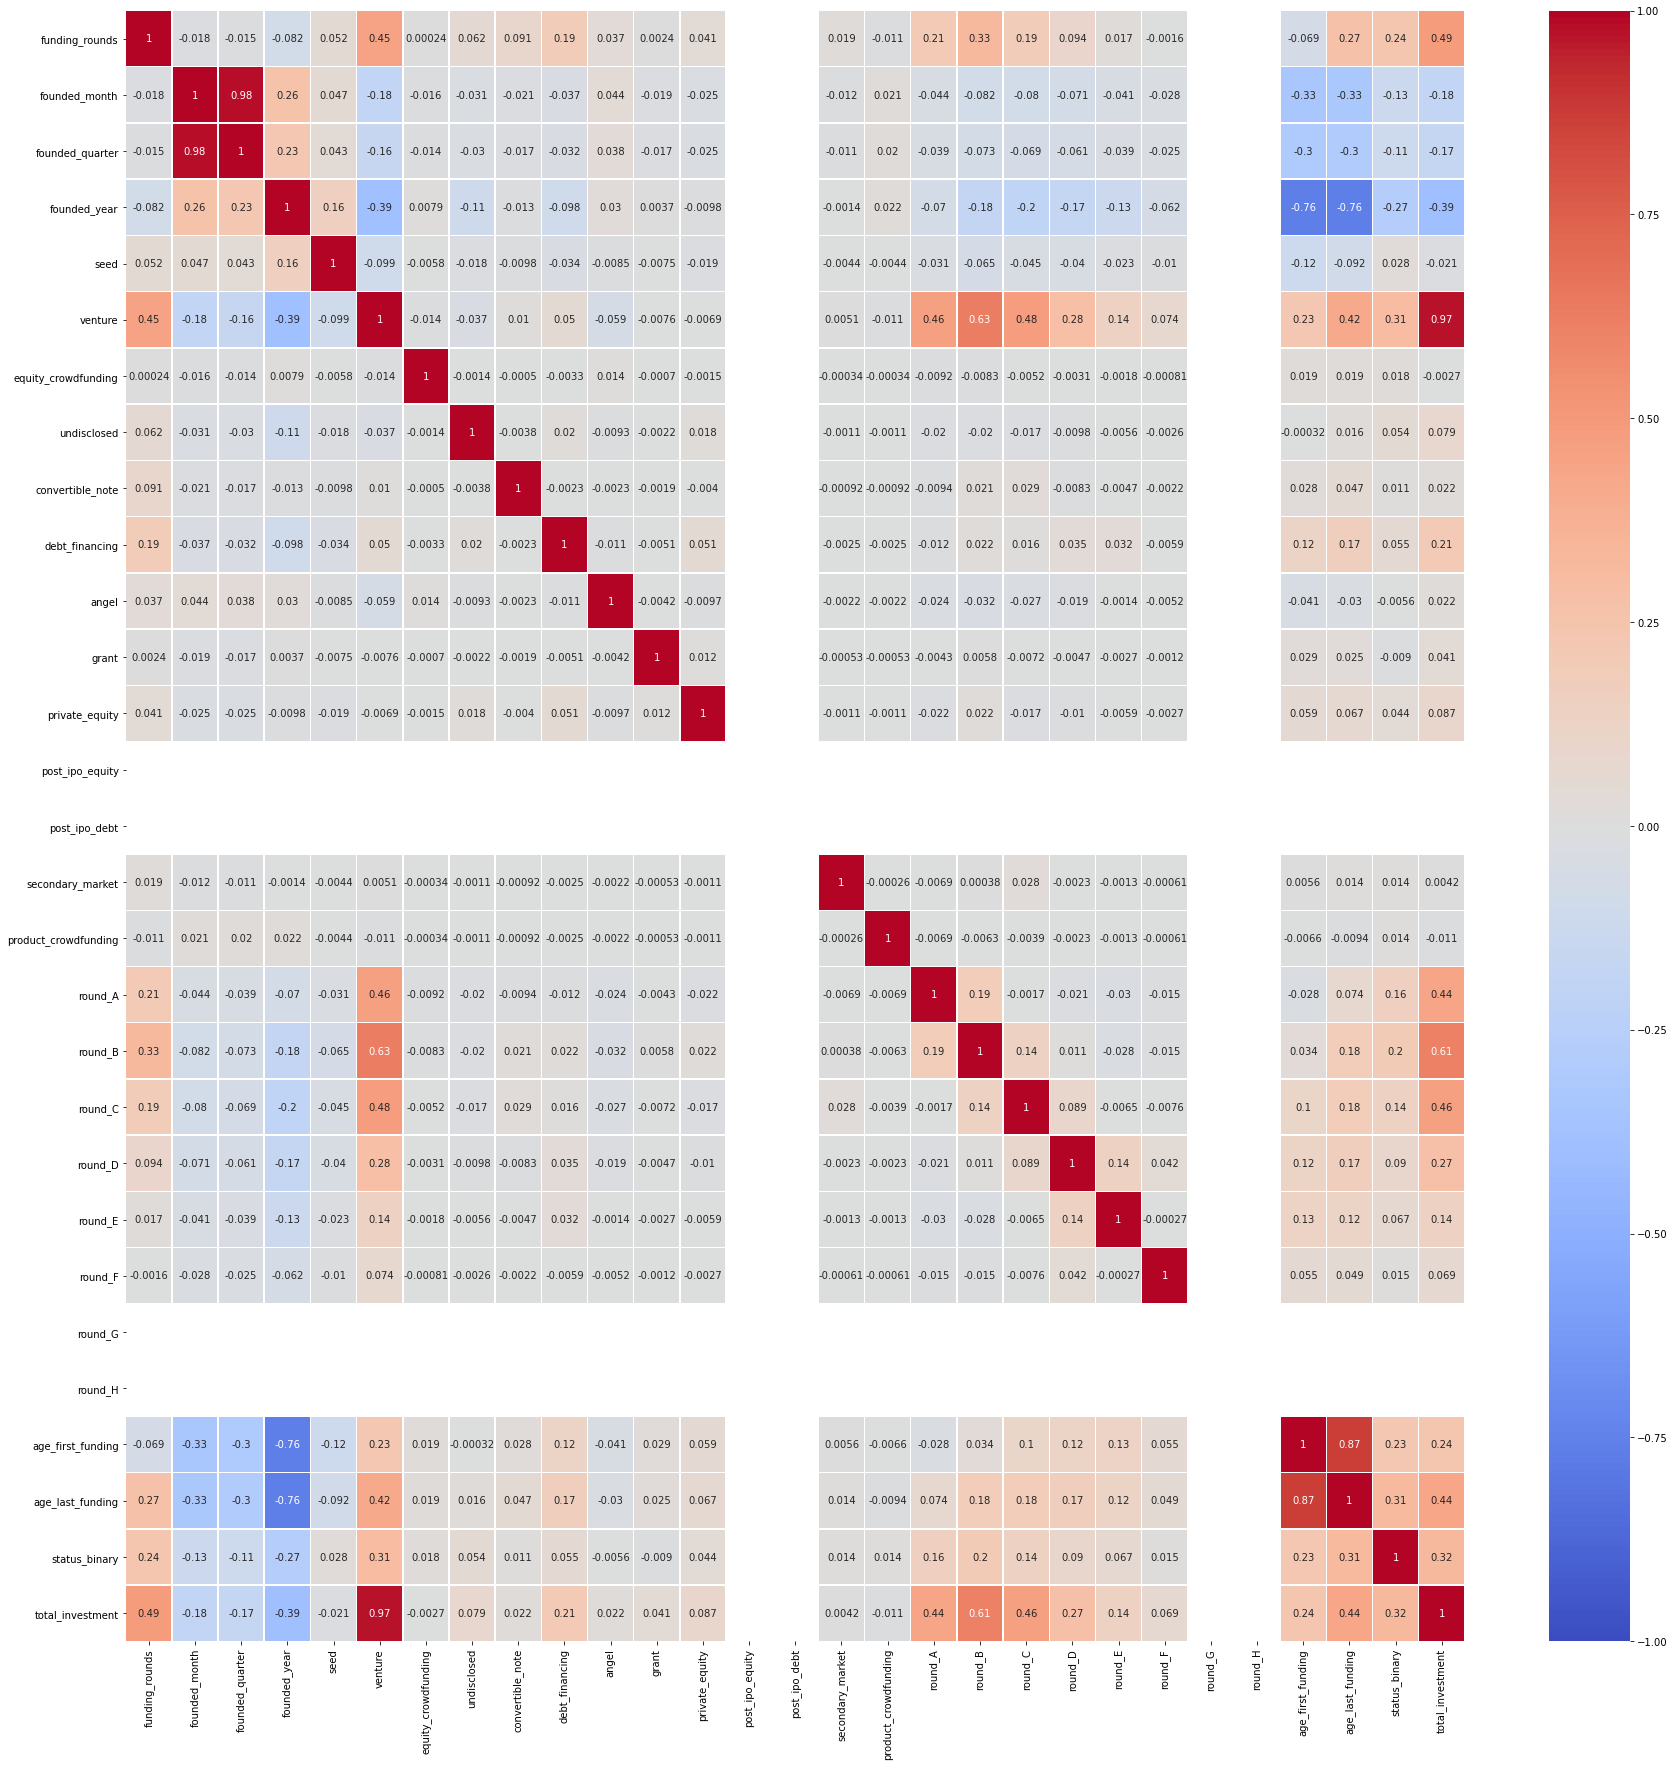

In [ ]:
plt.figure(figsize=(30,30))
startup_heat = startup_df.corr()

startup_heat= sns.heatmap(startup_heat, annot=True,linewidth = 0.5, cmap='coolwarm', vmin=-1, vmax=1)

bottom, top = startup_heat.get_ylim()
startup_heat.set_ylim(bottom, top)

plt.show()

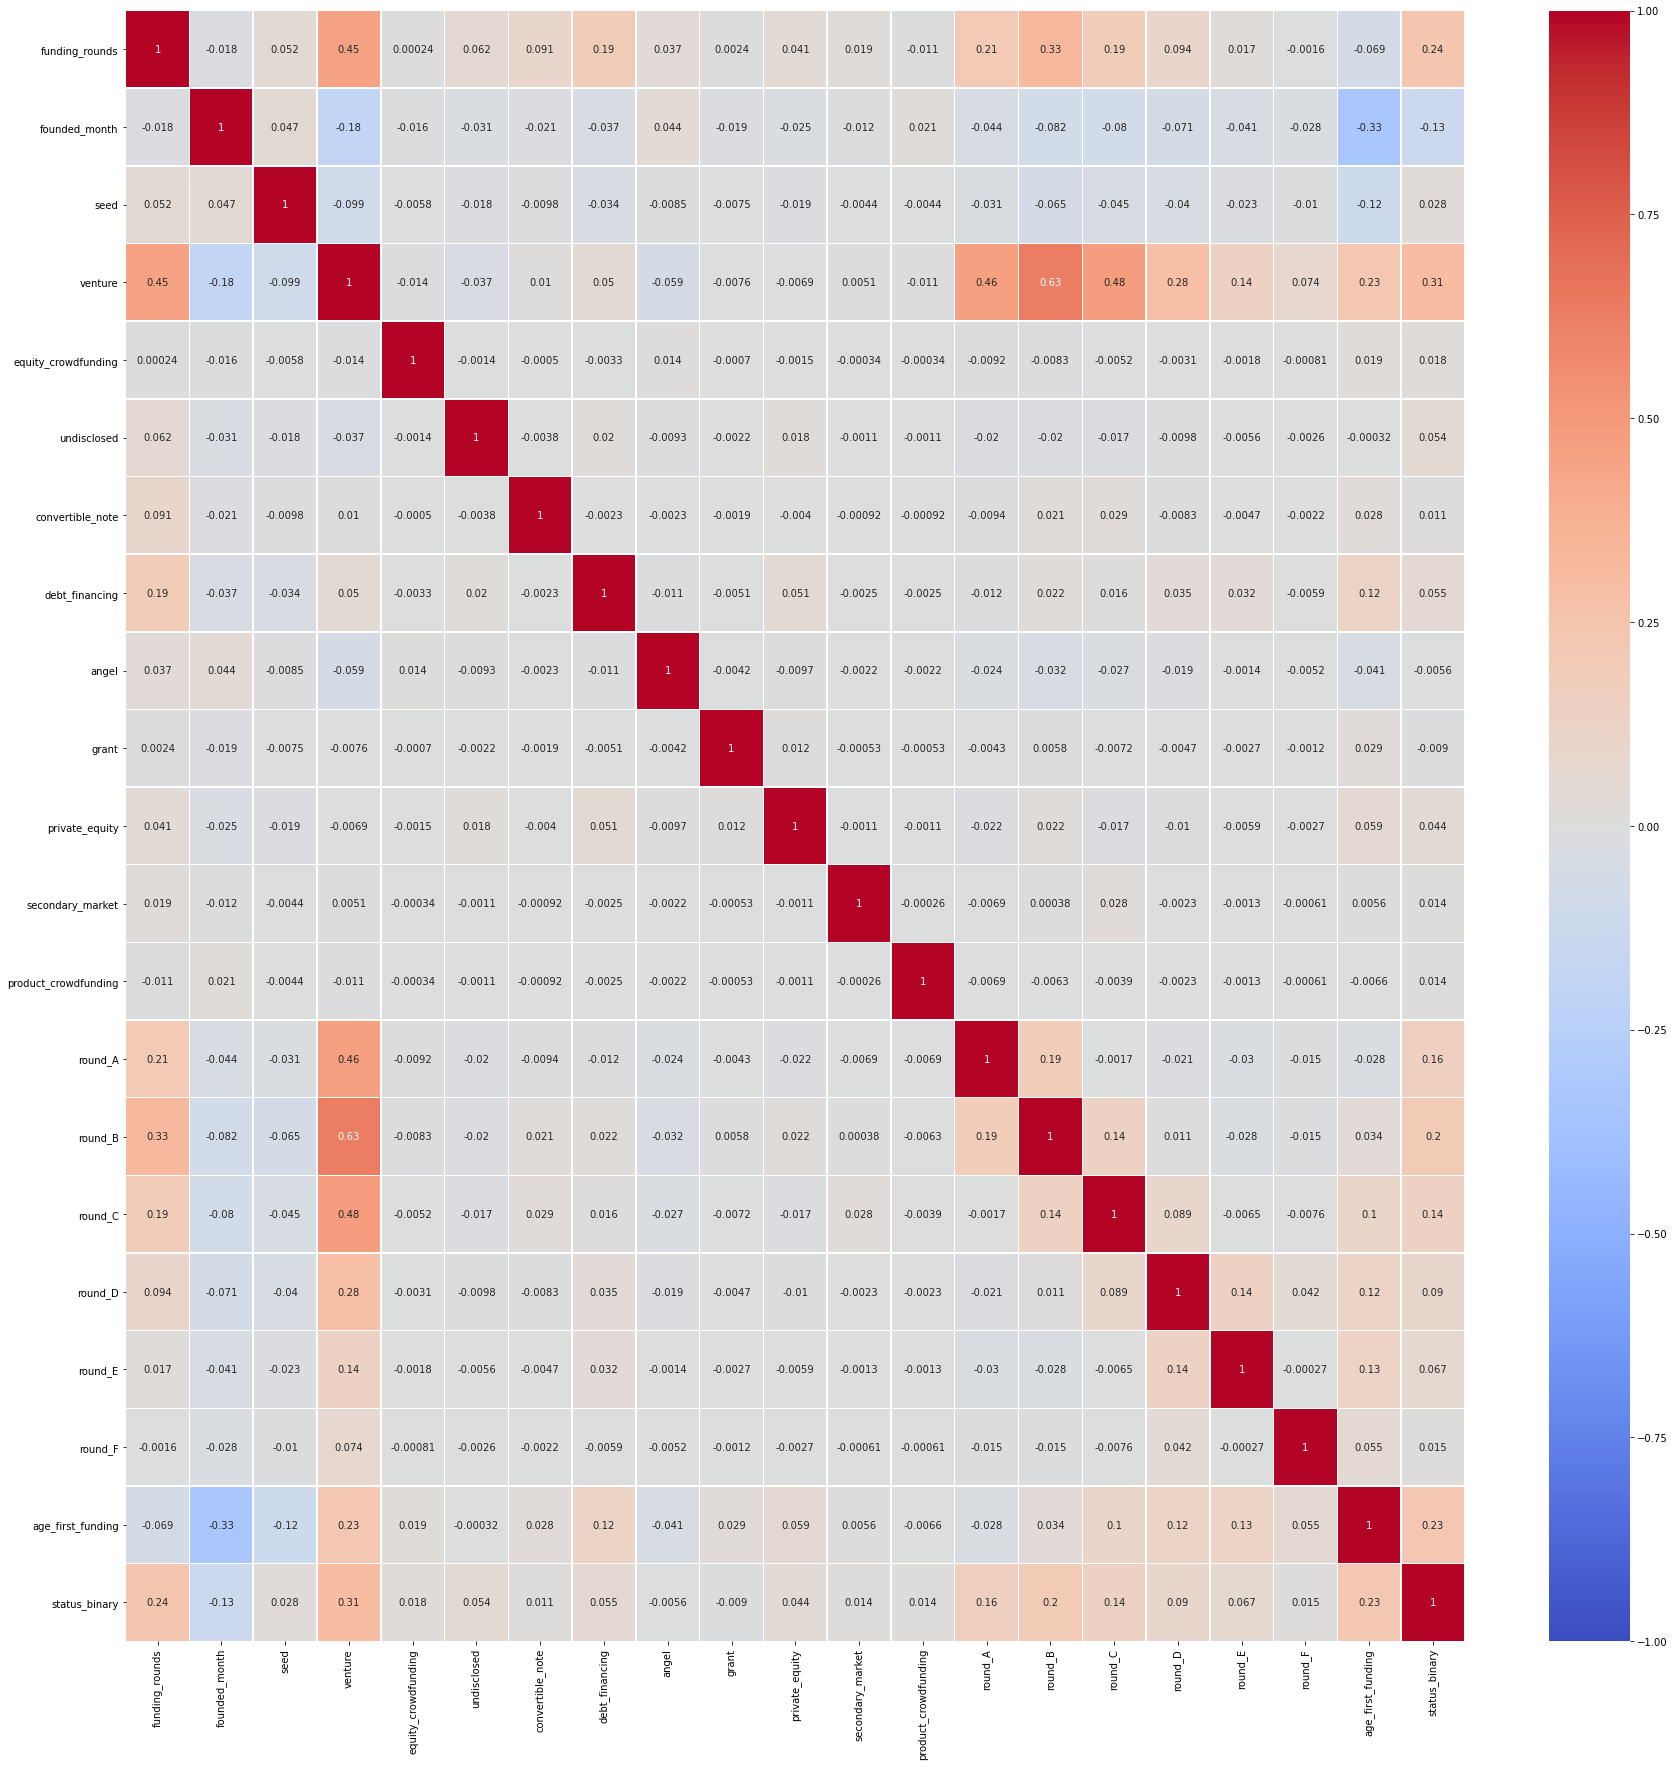

In [ ]:
#Hence, the correlation of a few different attributes are blank
#we are further excluding these from the model
startup_df = startup_df.drop(
    [
     'post_ipo_equity'
     ,'post_ipo_debt'
     ,'round_G'
     ,'round_H'
     ,'founded_year'
     ,'founded_quarter'
     ,'total_investment'
     ,'age_last_funding'
     ], axis = 1)

plt.figure(figsize=(30,30))
startup_heat = startup_df.corr()

startup_heat= sns.heatmap(startup_heat, annot=True,linewidth = 0.5, cmap='coolwarm', vmin=-1, vmax=1)

bottom, top = startup_heat.get_ylim()
startup_heat.set_ylim(bottom, top)

plt.show()

#### 3.7 Exporting data to Tableau



In [ ]:
#Exporting data to .CSV in order to explore data in Tableau
#startup_df.to_csv(r'startup_df_v2.csv', index = False, sep=';',mode='w')
#files.download('startup_df_v2.csv')

###**4. Data Modelling and Tuning**
Predicting successful start-ups


In [ ]:
#The initial process of the modelling phase is to create dummy variables
#and seperating the dataset into X and y

modelling_df = startup_df
X = pd.get_dummies(modelling_df.drop(['status_binary'],axis = 1))
y = modelling_df['status_binary']

In [ ]:
#Before modelling our data, we are creating a new dataframe, to reduce the complexity
#Further, we are the data into train and test identify potential overfitting patterns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 10)

#### 4.1 Random Forrest Classification




In [ ]:
#Testing the impact of increasing desicion trees used to predict y.
n = 10
while n <= 200:
  model = RandomForestClassifier(n_estimators=n)
  model.fit(X_train, y_train)
  print('{} - train score: {:.3f} | test score: {:.3f}'.format(n,model.score(X_train,y_train),model.score(X_test,y_test)))
  n = n+10

10 - train score: 0.975 | test score: 0.694
20 - train score: 0.988 | test score: 0.694
30 - train score: 0.990 | test score: 0.709
40 - train score: 0.992 | test score: 0.711
50 - train score: 0.992 | test score: 0.709
60 - train score: 0.992 | test score: 0.706
70 - train score: 0.992 | test score: 0.711
80 - train score: 0.992 | test score: 0.721
90 - train score: 0.992 | test score: 0.711
100 - train score: 0.992 | test score: 0.711
110 - train score: 0.992 | test score: 0.721
120 - train score: 0.992 | test score: 0.715
130 - train score: 0.992 | test score: 0.718
140 - train score: 0.992 | test score: 0.711
150 - train score: 0.992 | test score: 0.711
160 - train score: 0.992 | test score: 0.715
170 - train score: 0.992 | test score: 0.708
180 - train score: 0.992 | test score: 0.710
190 - train score: 0.992 | test score: 0.715
200 - train score: 0.992 | test score: 0.721


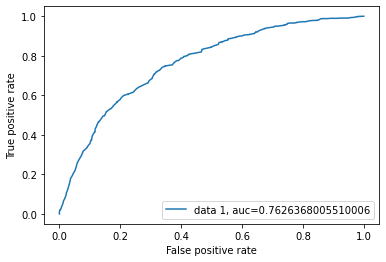

In [ ]:
model = RandomForestClassifier(n_estimators=110) 
model.fit(X_train, y_train)

#ROC CURVE - Plotting the true positives against the false positives and an AUC score
y_pred_proba = model.predict_proba(X_test) [:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc=4)
plt.show()

##### 4.2.1 Model tuning

In [ ]:
#To get an overview of the feature importance we can utilize from the 
#The feature_importances_ function was not used, because of bias when dealing with a high cardinality (according to the SKlearn documentation)
result = permutation_importance(model, X_train, y_train, n_repeats=10,random_state=0)
fimp = pd.Series(result.importances_mean,index=X_train.columns.values).sort_values(ascending=False)
fimp

venture                        0.181195
age_first_funding              0.180039
founded_month                  0.102004
funding_rounds                 0.099075
seed                           0.079653
round_A                        0.043931
market_Other                   0.040424
round_B                        0.036301
angel                          0.025973
debt_financing                 0.016185
market_Software                0.016108
market_Curated Web             0.013025
round_C                        0.010482
market_Mobile                  0.010443
market_Biotechnology           0.010173
market_Games                   0.009711
market_Enterprise Software     0.007630
market_Advertising             0.006166
market_Social Media            0.005588
round_D                        0.004355
market_Hardware + Software     0.004200
market_E-Commerce              0.004123
market_Semiconductors          0.003430
market_Clean Technology        0.003237
market_Web Hosting             0.002852


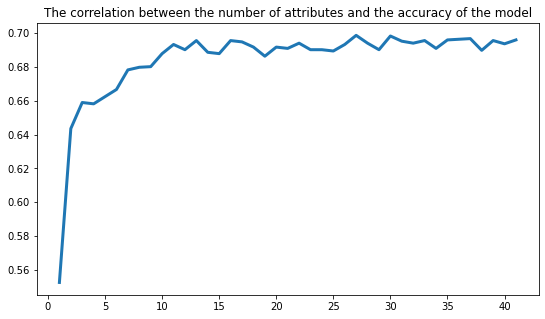

In [ ]:
#Based on the model accuracy from above, we can try to tune the performance by
#evaluating the accuracy by random selecting a number of decriptive attributes
#Further, we evaluate the model by the isolated attribute importance and then dropping insignificant attributes.

rfecv = RFECV(estimator=model, step=1,cv=StratifiedKFold(10),scoring='accuracy')
rfecv.fit(X_train,y_train)

plt.figure(figsize=(9,5))
plt.plot(range(1, len(rfecv.grid_scores_)+1),rfecv.grid_scores_,linewidth=3)
plt.title('The correlation between the number of attributes and the accuracy of the model')
plt.show()



In [ ]:
X_train.columns[np.where(rfecv.support_ == False)[0]]

Index(['equity_crowdfunding', 'convertible_note', 'private_equity',
       'secondary_market', 'product_crowdfunding', 'round_E', 'round_F',
       'market_Education ', 'market_Health Care ', 'market_Messaging ',
       'market_Search ', 'market_Security ', 'market_Semiconductors ',
       'market_Web Hosting '],
      dtype='object')

In [ ]:
#Based on the plot above, we are dropping all columns not categorized as supportive to our model
X.drop(X_train.columns[np.where(rfecv.support_ == False)[0]],axis=1, inplace = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
model.fit(X_train,y_train)

RandomForestClassifier(n_estimators=110)

In [ ]:
result = permutation_importance(model, X_train, y_train, n_repeats=10,random_state=0)
fimp = pd.Series(result.importances_mean,index=X_train.columns.values).sort_values(ascending=False)
fimp

age_first_funding              0.189865
venture                        0.181118
funding_rounds                 0.125819
founded_month                  0.095607
seed                           0.080231
market_Other                   0.052832
round_A                        0.045549
angel                          0.029827
round_B                        0.027900
market_Software                0.018805
debt_financing                 0.017495
market_Curated Web             0.015530
round_C                        0.009634
market_Mobile                  0.009595
market_Social Media            0.008555
market_Games                   0.008054
market_Biotechnology           0.006705
market_Enterprise Software     0.005703
market_Hardware + Software     0.005010
market_E-Commerce              0.004740
market_Advertising             0.004740
market_Clean Technology        0.004239
round_D                        0.003391
market_Finance                 0.002235
grant                          0.001541


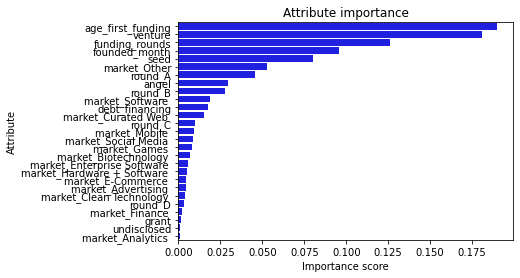

In [ ]:
#Plotting feature importance
sns.barplot(x=fimp, y=fimp.index, color='b')
plt.rcParams['figure.figsize'] = 6,15
plt.xlabel('Importance score')
plt.ylabel('Attribute')
plt.title('Attribute importance')

plt.show()

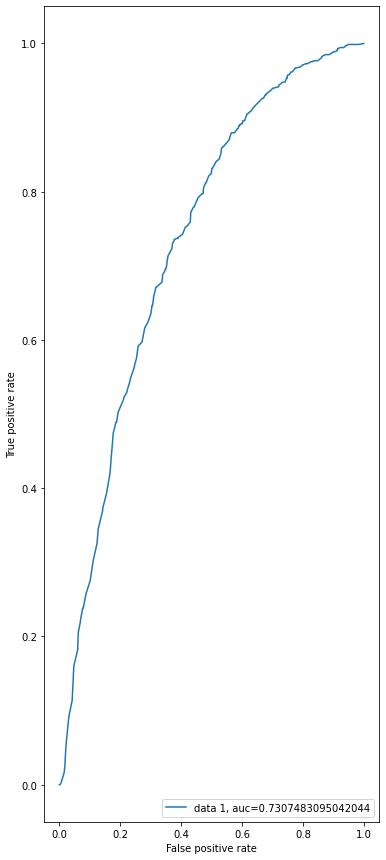

In [ ]:
#Plotting another ROC curve to benchmark the initial model against the tuned version.
y_pred_proba = model.predict_proba(X_test) [:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc=4)
plt.show()

In [ ]:
#Further, we create a new model, embedded with a cross-validation to evaluate the performance of the model across 10 folds repeating 5 times
cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cross_val, n_jobs=-1, error_score='raise')
# report performance
print('Average score of 5 run with a stratified 10 Kfold is {:.3f} with a standard deviation of: {:.3f}'.format(np.mean(scores)*100, np.std(scores)))

Average score of 5 run with a stratified 10 Kfold is 71.692 with a standard deviation of: 0.024


In [ ]:
#Finally, we can try to use our model to predict a the future state of a startup in isolation
#To do this, we can make use of to predict function, but first we need to create a new dataframe with our target

pred = X_test.sample(n=1)
outcome = model.predict(pred)
print('Predicted Class: {}'.format(outcome[0]))

if outcome == 1:
  print('This startup is predicted to be successful by {:.1f}%'.format(np.mean(scores)*100)) 
  display(pred)
elif outcome == 0:
  print('This startup is predicted NOT to be successful by {:.1f}%'.format(np.mean(scores)*100)) 
  display(pred)
#To use this in a real life setting, one could benefit from this by replacing 'pred' with another dataframe
#containing a startup with that has the potential of being a successfull startup and hereby also needed to be investigated

Predicted Class: 0
This startup is predicted NOT to be successful by 71.7%


,funding_rounds,founded_month,seed,venture,undisclosed,debt_financing,angel,grant,round_A,round_B,...,market_Curated Web,market_E-Commerce,market_Enterprise Software,market_Finance,market_Games,market_Hardware + Software,market_Mobile,market_Other,market_Social Media,market_Software
30028,1.0,6.0,30000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0


#### 4.2 Logistic regression




In [ ]:
#To evaluate the true performance of a logistic regression, we are once again including all attributes
X = pd.get_dummies(modelling_df.drop(['status_binary'],axis = 1))
y = modelling_df['status_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

logreg = LogisticRegressionCV(max_iter=10000, scoring='roc_auc')
logreg.fit(X_train,y_train)

print('The training model accuracy: {:.4}'.format(logreg.score(X_train,y_train)))
print('The test model accuracy: {:.4}'.format(logreg.score(X_test,y_test)))

The training model accuracy: 0.7238
The test model accuracy: 0.7528


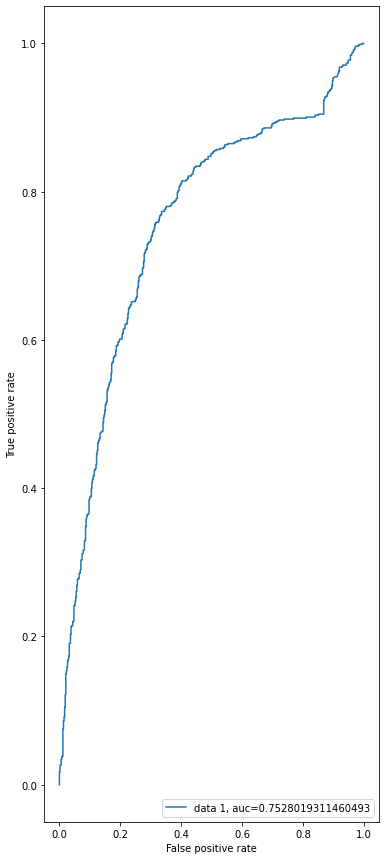

In [ ]:
#ROC CURVE - Plotting the true positives against the false positives
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc=4)
plt.show()

##### 4.1.1 Model tuning

In [ ]:
#Trying to balance the classes in order to achieve a better result
logreg = LogisticRegressionCV(max_iter=10000,scoring='roc_auc',class_weight='balanced')
logreg.fit(X_train,y_train)

print('The training model accuracy: {:.4}'.format(logreg.score(X_train,y_train)))
print('The test model accuracy: {:.4}'.format(logreg.score(X_test,y_test)))

The training model accuracy: 0.7255
The test model accuracy: 0.7503


In [ ]:
#Fitting the model with both a balanced and the liblinear as the solver
#**Liblinear is described in docu as a solid choice for small datasets**
logreg = LogisticRegressionCV(penalty='l1', solver='liblinear',scoring='roc_auc',class_weight='balanced', max_iter=100000)
logreg.fit(X_train,y_train)

print('The training model accuracy: {:.4}'.format(logreg.score(X_train,y_train)))
print('The test model accuracy: {:.4}'.format(logreg.score(X_test,y_test)))

The training model accuracy: 0.7504
The test model accuracy: 0.7836


In [ ]:
#Fitting the model with both a balanced and 
#from sklearn.metrics import mean_squared_error
logreg = LogisticRegressionCV(penalty='l1', solver='liblinear', max_iter=10000,scoring='roc_auc')
logreg.fit(X_train,y_train)

print('The training model accuracy: {:.4}'.format(logreg.score(X_train,y_train)))
print('The test model accuracy: {:.4}'.format(logreg.score(X_test,y_test)))

#print('Mean square error: {:.4}'.format(mean_squared_error(y_test, y_train)))
#print('Root mean square error: {:.4}'.format(mean_squared_error(y_test, y_train)))

The training model accuracy: 0.7597
The test model accuracy: 0.7924


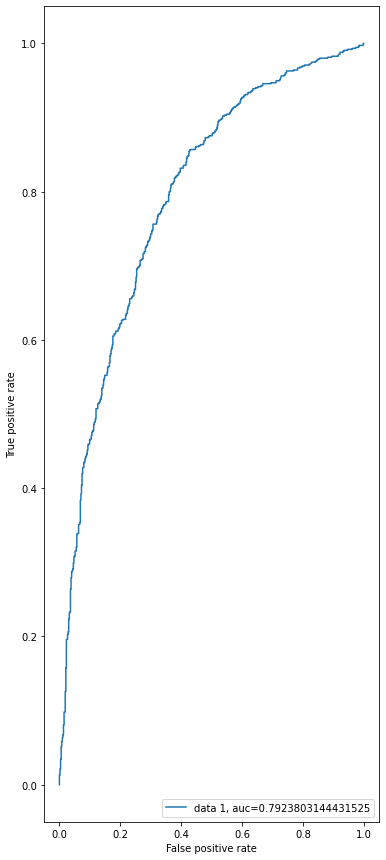

In [ ]:
#ROC CURVE - Plotting the true positives against the false positives
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc=4)
plt.show()

###**5. Data Evaluation**
Predicting successful start-ups


In [ ]:
modelling_df.groupby('status_binary').agg({'status_binary':'count'})

,status_binary
status_binary,
0,1619
1,2255


*Hence our dataset is inbalanced, we can apply SMOTE to balance the difference between successfull and non-successfull startups. SMOTE is using knearestneighbor, to create new rows by not copying but rather simulating existing rows.*


*We can the try to apply SMOTE to the training data and they carry out the two ML models from the previous chapter once again.*

*However, it is important, that we only do a SMOTE on the training data, because information from the target variable then is restricted to only training and the real performance of the test is then isolated.*

In [ ]:
modelling_df = startup_df
X = pd.get_dummies(modelling_df.drop(['status_binary'],axis = 1))
y = modelling_df['status_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 0)



In [ ]:
oversample = SMOTE()

os_X,os_y =oversample.fit_resample(X_train, y_train)
os_X = pd.DataFrame(data= os_X,columns = col )
os_y = pd.DataFrame(data= os_y)

NameError: name 'col' is not defined

In [ ]:
os_y

0       0
1       1
2       1
3       0
4       0
       ..
2997    0
2998    0
2999    0
3000    0
3001    0
Name: status_binary, Length: 3002, dtype: int64

In [ ]:
#Then we can evaluate the SMOTE function, to understand how we have extended our data

print("length of undersampled data is ",len(os_X))
print("Number of closed startups in undersampled data",len(os_y[os_y['status_binary']==0]))
print("Number of succesfull startups",len(os_y[os_y['status_binary']==1]))
print("Proportion of closed startups in undersampled data is {}%".format(len(os_y[os_y['status_binary']==0])/len(os_X)*100))
print("Proportion of succesfull startups in undersampled data is {}%".format(len(os_y[os_y['status_binary']==1])/len(os_X)*100))

length of undersampled data is  3002


KeyError: 'status_binary'

##### 5.3 Random forrest w. balanced data

In [ ]:
X = os_X
y = os_y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 0)

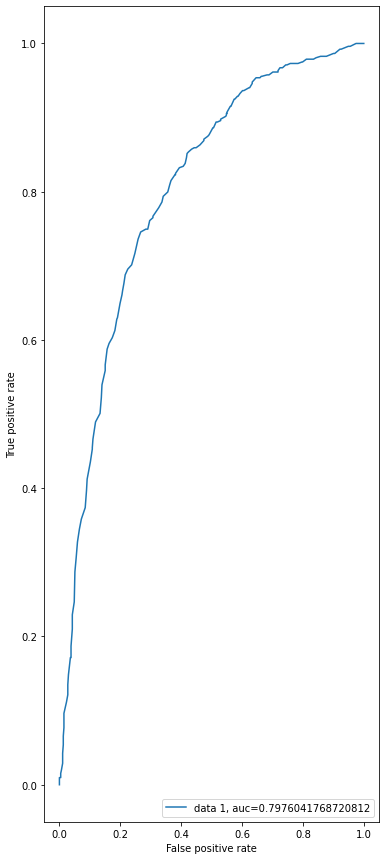

In [ ]:
model = RandomForestClassifier(n_estimators=110) 
model.fit(X_train, y_train)

#ROC CURVE - Plotting the true positives against the false positives and an AUC score
y_pred_proba = model.predict_proba(X_test) [:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc=4)
plt.show()


> Hence, we did not recived great success while tuning the random forrest model from chapter 3, we leave the model by it's original state and do not exclude attributes by performing a RFECV (Recursive Feature Elimination.Cross-alidation)




##### 5.2 Logistic regression w. balanced data

In [ ]:
logreg = LogisticRegressionCV(penalty='l1', solver='liblinear', max_iter=10000, scoring='roc_auc')
logreg.fit(os_X,os_y)

print('The training model accuracy (balanced): {:.4} %'.format(logreg.score(os_X,os_y)*100))
print('The test model accuracy: {:.4}'.format(logreg.score(X_test,y_test)*100))

The training model accuracy (balanced): 81.87 %
The test model accuracy: 81.42


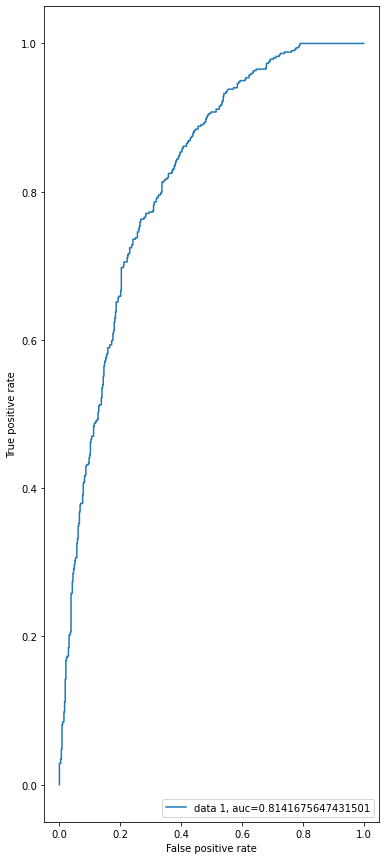

In [ ]:
#ROC CURVE - Plotting the true positives against the false positives
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc=4)
plt.show()

###**5. Deployment**
The deployment of a random forrest model to classify successfull startups.


In [ ]:
#Finally, we can try to use our model to predict a the future state of a startup in isolation
#To do this, we can make use of to predict function, but first we need to create a new dataframe with our target

#Training the model once again with the balanced data from SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 0)

model.fit(X_train, y_train)
pred = X_test.sample(n=1)
outcome = model.predict(pred)

y_pred_proba = model.predict_proba(X_test) [:,1]
auc = metrics.roc_auc_score(y_test, y_pred_proba)

print('Predicted Class: {}'.format(outcome[0]))

if outcome == 1:
  print('This startup is predicted to be successful by {:.1f}%'.format(auc*100)) 
  display(pred)
elif outcome == 0:
  print('This startup is predicted NOT to be successful by {:.1f}%'.format(auc*100)) 
  display(pred)

#To use this in a real life setting, one could benefit from this by replacing 'pred' with another user based dataframe
#containing a startup with that has the potential of being a successfull startup and hereby also needed to be investigated
#This is shown below

Predicted Class: 0
This startup is predicted NOT to be successful by 79.5%


,funding_rounds,founded_month,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,...,market_Health Care,market_Messaging,market_Mobile,market_Other,market_Search,market_Security,market_Semiconductors,market_Social Media,market_Software,market_Web Hosting
2263,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0


Tableau Software was recently acquired by Salesforce. However, they are categorized as a operational company in our dataset. To test the performance of our model, we can try see how the model perform on Tableau:

In [ ]:
prod_dict = {'funding_rounds':              [2.0]
            ,'founded_month':               [1.0]
            ,'seed':                        [0.0]
            ,'venture':                     [15000000.0]
            ,'equity_crowdfunding':         [0.0]
            ,'undiscolsed':                 [0.0]
            ,'convertible_note':            [0.0]
            ,'debt_financing':              [0.0]
            ,'angel':                       [0.0]
            ,'grant':                       [0.0]
            ,'private equity':              [0.0]
            ,'secondary_market':            [0.0]
            ,'product_crowdfunding':        [0.0]
            ,'round_A':                     [5000000.0]
            ,'round_B':                     [10000000.0]
            ,'round_C':                     [0.0]
            ,'round_D':                     [0.0]
            ,'round_E':                     [0.0]
            ,'round_F':                     [0.0]
            ,'age_first_funding':           [1.0]
            ,'market_Advertising':          [0.0]
            ,'market_Analytics ':           [0.0]
            ,'market_Biotechnology ':       [0.0]
            ,'market_Clean Technology ':    [0.0]
            ,'market_Curated Web ':         [0.0]
            ,'market_E-Commerce ':          [0.0]
            ,'market_Education':            [0.0]
            ,'market_Enterprise Software ': [0.0]
            ,'market_Finance ':             [0.0]
            ,'market_Games ':               [0.0]
            ,'market_Hardware + Software ': [0.0]
            ,'market_Health care ':         [0.0] 
            ,'market_Messaging ':           [0.0]
            ,'market_Mobile ':              [0.0]
            ,'market_Other':                [0.0]
            ,'market_Search ':              [0.0]
            ,'market_Security':             [0.0]
            ,'market_Semiconductors ':      [0.0]
            ,'market_Social Media ':        [0.0]
            ,'market_Software ':            [1.0]
            ,'market_Web Hosting ':         [0.0]
            }
prod_pred = pd.DataFrame(data=prod_dict)
outcome = model.predict(prod_pred)

print('Predicted Class: {}'.format(outcome[0]))

if outcome == 1:
  print('This startup is predicted to be successful by {:.1f}%'.format(auc*100)) 
elif outcome == 0:
  print('This startup is predicted NOT to be successful by {:.1f}%'.format(auc*100)) 
display(prod_pred)

Predicted Class: 1
This startup is predicted to be successful by 79.5%


,funding_rounds,founded_month,seed,venture,equity_crowdfunding,undiscolsed,convertible_note,debt_financing,angel,grant,...,market_Health care,market_Messaging,market_Mobile,market_Other,market_Search,market_Security,market_Semiconductors,market_Social Media,market_Software,market_Web Hosting
0,2.0,1.0,0.0,15000000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Slack software

In [ ]:
prod_dict = {'funding_rounds':              [6.0]
            ,'founded_month':               [1.0]
            ,'seed':                        [1500000.0]
            ,'venture':                     [178450000.0]
            ,'equity_crowdfunding':         [0.0]
            ,'undiscolsed':                 [0.0]
            ,'convertible_note':            [0.0]
            ,'debt_financing':              [0.0]
            ,'angel':                       [0.0]
            ,'grant':                       [0.0]
            ,'private equity':              [0.0]
            ,'secondary_market':            [0.0]
            ,'product_crowdfunding':        [0.0]
            ,'round_A':                     [5000000.0]
            ,'round_B':                     [10700000.0]
            ,'round_C':                     [42750000.0]
            ,'round_D':                     [120000000.0]
            ,'round_E':                     [0.0]
            ,'round_F':                     [0.0]
            ,'age_first_funding':           [0.0]
            ,'market_Advertising':          [0.0]
            ,'market_Analytics ':           [0.0]
            ,'market_Biotechnology ':       [0.0]
            ,'market_Clean Technology ':    [0.0]
            ,'market_Curated Web ':         [0.0]
            ,'market_E-Commerce ':          [0.0]
            ,'market_Education':            [0.0]
            ,'market_Enterprise Software ': [1.0]
            ,'market_Finance ':             [0.0]
            ,'market_Games ':               [0.0]
            ,'market_Hardware + Software ': [0.0]
            ,'market_Health care ':         [0.0] 
            ,'market_Messaging ':           [0.0]
            ,'market_Mobile ':              [0.0]
            ,'market_Other':                [0.0]
            ,'market_Search ':              [0.0]
            ,'market_Security':             [0.0]
            ,'market_Semiconductors ':      [0.0]
            ,'market_Social Media ':        [0.0]
            ,'market_Software ':            [0.0]
            ,'market_Web Hosting ':         [0.0]
            }
prod_pred = pd.DataFrame(data=prod_dict)
outcome = model.predict(prod_pred)

print('Predicted Class: {}'.format(outcome[0]))

if outcome == 1:
  print('This startup is predicted to be successful by {:.1f}%'.format(auc*100)) 
elif outcome == 0:
  print('This startup is predicted NOT to be successful by {:.1f}%'.format(auc*100)) 
display(prod_pred)

Predicted Class: 1
This startup is predicted to be successful by 79.5%


,funding_rounds,founded_month,seed,venture,equity_crowdfunding,undiscolsed,convertible_note,debt_financing,angel,grant,...,market_Health care,market_Messaging,market_Mobile,market_Other,market_Search,market_Security,market_Semiconductors,market_Social Media,market_Software,market_Web Hosting
0,6.0,1.0,1500000.0,178450000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Jawbone - a consumer hardware producer, that shut down their operations and currently undergoing a liquidation because of several lawsuits from creditors

In [ ]:
prod_dict = {'funding_rounds':              [11.0]
            ,'founded_month':               [1.0]
            ,'seed':                        [0.0]
            ,'venture':                     [188799995.0]
            ,'equity_crowdfunding':         [0.0]
            ,'undiscolsed':                 [0.0]
            ,'convertible_note':            [0.0]
            ,'debt_financing':              [93000000.0]
            ,'angel':                       [0.0]
            ,'grant':                       [0.0]
            ,'private equity':              [237000000.0]
            ,'secondary_market':            [0.0]
            ,'product_crowdfunding':        [0.0]
            ,'round_A':                     [5000000.0]
            ,'round_B':                     [70000000.0]
            ,'round_C':                     [0.0]
            ,'round_D':                     [0.0]
            ,'round_E':                     [63999995.0]
            ,'round_F':                     [0.0]
            ,'age_first_funding':           [7.95]
            ,'market_Advertising':          [0.0]
            ,'market_Analytics ':           [0.0]
            ,'market_Biotechnology ':       [0.0]
            ,'market_Clean Technology ':    [0.0]
            ,'market_Curated Web ':         [0.0]
            ,'market_E-Commerce ':          [0.0]
            ,'market_Education':            [0.0]
            ,'market_Enterprise Software ': [0.0]
            ,'market_Finance ':             [0.0]
            ,'market_Games ':               [0.0]
            ,'market_Hardware + Software ': [0.0]
            ,'market_Health care ':         [0.0] 
            ,'market_Messaging ':           [0.0]
            ,'market_Mobile ':              [0.0]
            ,'market_Other':                [1.0]
            ,'market_Search ':              [0.0]
            ,'market_Security':             [0.0]
            ,'market_Semiconductors ':      [0.0]
            ,'market_Social Media ':        [0.0]
            ,'market_Software ':            [0.0]
            ,'market_Web Hosting ':         [0.0]
            }
prod_pred = pd.DataFrame(data=prod_dict)
outcome = model.predict(prod_pred)

print('Predicted Class: {}'.format(outcome[0]))

if outcome == 1:
  print('This startup is predicted to be successful by {:.1f}%'.format(auc*100)) 
elif outcome == 0:
  print('This startup is predicted NOT to be successful by {:.1f}%'.format(auc*100)) 
display(prod_pred)

Predicted Class: 1
This startup is predicted to be successful by 79.5%


,funding_rounds,founded_month,seed,venture,equity_crowdfunding,undiscolsed,convertible_note,debt_financing,angel,grant,...,market_Health care,market_Messaging,market_Mobile,market_Other,market_Search,market_Security,market_Semiconductors,market_Social Media,market_Software,market_Web Hosting
0,11.0,1.0,0.0,188799995.0,0.0,0.0,0.0,93000000.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
